# Load trip data and shapefiles

In [ ]:
%run spatial_analysis_load.ipynb

working dir: /opt/dssg-hot/notebooks/shirley


# Group trips

#### Create groupby objects

In [2]:
fips_grouped = dfnow.groupby('fips')

In [3]:
fips_sov_grouped = dfnow[dfnow['is_hov']==0].groupby('fips')
fips_hov_grouped = dfnow[dfnow['is_hov']==1].groupby('fips')

#### Compute groups (toll intervals, time of use, user frequency, length of HOT trip)

<i>For grouping trips by toll</i>

In [ ]:
def toll_group_fxn(row):
    if row['toll']<=1:
        val = "0-1"
    elif (row['toll']>1) & (row['toll']<=2):
        val = ">1-2"
    elif (row['toll']>2) & (row['toll']<=4):
        val = ">2-4"      
    elif (row['toll']>4) & (row['toll']<=6):
        val = ">4-6"
    elif (row['toll']>6) & (row['toll']<=8):
        val = ">6-8"
    elif (row['toll']>8) & (row['toll']<=10):
        val = ">8-10"
    else:
        val = ">10?"
    return val

dfnow['toll_group'] = dfnow.apply(toll_group_fxn, axis=1)

<i>For grouping trips by week day, month, time of day</i>

In [4]:
dfnow['entry_time'] = pd.to_datetime(dfnow['entry_time'],unit='s')
#dfnow['entry_day'] = dfnow['entry_time'].apply(lambda t: t.weekday())
#dfnow['entry_mon'] = dfnow['entry_time'].apply(lambda t: t.month)
dfnow['entry_hr'] = dfnow['entry_time'].apply(lambda t: t.hour)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [5]:
# morning peak = 5-10am, evening peak = 3-8pm
def peak_group_fxn(row):
    if (row['entry_hr']>=5) & (row['entry_hr']<=9) & (row['entry_plaza']<13):
        val = "NB_m_pk"
    elif (row['entry_hr']>=5) & (row['entry_hr']<=9) & (row['entry_plaza']>=13):
        val = "SB_m_pk"
    elif (row['entry_hr']>=15) & (row['entry_hr']<=19) & (row['entry_plaza']<13):
        val = "NB_e_pk"
    elif (row['entry_hr']>=15) & (row['entry_hr']<=19) & (row['entry_plaza']>=13):
        val = "SB_e_pk"
    else:
        val = "offpk"
    return val

dfnow['peak_group'] = dfnow.apply(peak_group_fxn, axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


<i>For grouping trips by user frequency</i>

In [26]:
fips_id_lookup = dfnow.drop_duplicates('id', keep='first')[['id','fips']]
#fips_id_lookup = pd.read_sql_query("select fips, id from census;", db)
#print(len(fips_id_lookup))
#fips_id_lookup.head()

In [27]:
num_trips_by_id = dfnow.agg({'id':'value_counts'}) # counts how many times each value appears in the column = # of trips per id
num_trips_by_id.rename(columns={'id': 'num_trips_by_id'}, inplace=True)
num_trips_by_id['id'] = num_trips_by_id.index
num_trips_by_id_fips = pd.merge(num_trips_by_id, fips_id_lookup, how='left', on='id')

In [28]:
def freq_group_fxn(row):
    if row['num_trips_by_id']==1:
        val = "1"
    elif (row['num_trips_by_id']>=2) & (row['num_trips_by_id']<=20):
        val = "2-20"
    elif (row['num_trips_by_id']>20) & (row['num_trips_by_id']<=70):
        val = "21-70"      
    elif (row['num_trips_by_id']>70) & (row['num_trips_by_id']<=200):
        val = "71-200"
    elif (row['num_trips_by_id']>200) & (row['num_trips_by_id']<=400):
        val = "201-400"
    elif (row['num_trips_by_id']>400):
        val = ">401"
    else:
        val = "0?"
    return val

In [29]:
num_trips_by_id_fips['freq_group'] = num_trips_by_id_fips.apply(freq_group_fxn, axis=1)

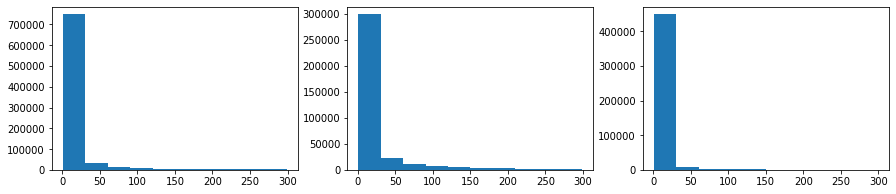

In [10]:
# - check how many id's have an associated fips
all_trips = num_trips_by_id_fips[(num_trips_by_id_fips['num_trips_by_id']>0) 
                             & (num_trips_by_id_fips['num_trips_by_id']<300)]['num_trips_by_id']
all_trips_wofips = num_trips_by_id_fips[(~num_trips_by_id_fips['fips'].isna()) 
              & (num_trips_by_id_fips['num_trips_by_id']>0) 
              & (num_trips_by_id_fips['num_trips_by_id']<300)]['num_trips_by_id']
all_trips_wfips = num_trips_by_id_fips[(num_trips_by_id_fips['fips'].isna()) 
              & (num_trips_by_id_fips['num_trips_by_id']>0)
              & (num_trips_by_id_fips['num_trips_by_id']<300)]['num_trips_by_id']

fig,axs=plt.subplots(1,3, figsize=(15,3))
axs[0].hist(all_trips); axs[1].hist(all_trips_wofips); axs[2].hist(all_trips_wfips);

In [11]:
print('# of trips w/o fips: ' + str(dfnow['fips'].isna().sum()))
print('total # of trips: ' + str(len(dfnow)))
print('frac of trips w/o fips: ' + str(dfnow['fips'].isna().sum()/len(dfnow)))

# of trips w/o fips: 5836315
total # of trips: 15365032
frac of trips w/o fips: 0.37984398600666763


In [12]:
print('# of ids w/o fips: ' + str(num_trips_by_id_fips['fips'].isna().sum()))
print('total # of ids: ' + str(len(num_trips_by_id_fips)))
print('frac of ids w/o fips: ' + str(num_trips_by_id_fips['fips'].isna().sum()/len(num_trips_by_id_fips)))

# of ids w/o fips: 463888
total # of ids: 826679
frac of ids w/o fips: 0.5611464667664232


In [30]:
num_trips_by_id_fips.head()

,num_trips_by_id,id,freq_group
fips,,,
5.306105e+11,3076,6.784643e+17,>401
5.303303e+11,2556,5.985664e+18,>401
5.307300e+11,1543,-5.974084e+18,>401
5.303301e+11,1503,-6.948487e+18,>401
5.306105e+11,1438,-8.703600e+18,>401


<i>For grouping trips by HOT lane trip length</i>

In [ ]:
def dist_group_fxn(row):
    if row['Dist btwn entry & exit loop']<=4:
        val = "0-4"
    elif (row['Dist btwn entry & exit loop']>4) & (row['Dist btwn entry & exit loop']<=6):
        val = ">4-6"
    elif (row['Dist btwn entry & exit loop']>6) & (row['Dist btwn entry & exit loop']<=8):
        val = ">6-8"      
    elif (row['Dist btwn entry & exit loop']>8) & (row['Dist btwn entry & exit loop']<=10):
        val = ">8-10"  
    elif (row['Dist btwn entry & exit loop']>10) & (row['Dist btwn entry & exit loop']<=12):
        val = ">10-12"  
    elif (row['Dist btwn entry & exit loop']>12):
        val = ">12"  
    else:
        val = "?"
    return val

dfnow['dist_group'] = dfnow.apply(dist_group_fxn, axis=1)

<i>For grouping trips by income</i>

In [14]:
cbgs_joinnow = cbgs_acs.merge(fips_sov_grouped.agg({'toll': 'mean'}), on='fips', how='left') # avg toll over sov per bg
print('# of bgs: ' + str(len(cbgs_joinnow)))
print('# of null tolls: ' + str(len(cbgs_joinnow[cbgs_joinnow['toll'].isnull()])))
print('# of null tolls or med incs: ' + str(len(cbgs_joinnow[cbgs_joinnow['med_inc'].isnull() | cbgs_joinnow['toll'].isnull()])))

# of bgs: 3166
# of null tolls: 635
# of null tolls or med incs: 668


In [15]:
filternow = ~(cbgs_joinnow['med_inc'].isnull() | cbgs_joinnow['toll'].isnull())
cbgs_joinnow = cbgs_joinnow[filternow]

In [16]:
dfnow = dfnow.merge(cbgs_joinnow[['med_inc','fips']], on='fips', how='left')

all acs bgs med inc: 74870.0
cbgs join bgs med inc: 79558.0
all trips bgs med inc: 99135.0


/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


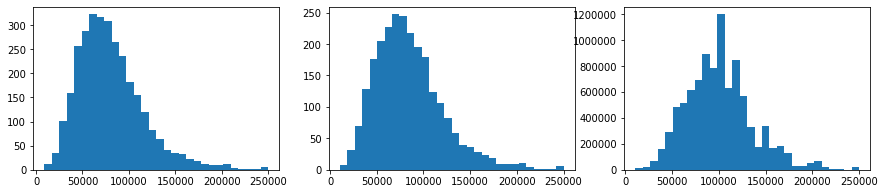

In [17]:
# - Compare income distribs from all acs, cbgs join (each fips wt = 1), all trips bgs (each fips wt = # of trips from that fips) 
print('all acs bgs med inc: ' + str(cbgs_acs['med_inc'].median()))
print('cbgs join bgs med inc: ' + str(cbgs_joinnow['med_inc'].median()))
print('all trips bgs med inc: ' + str(dfnow['med_inc'].median()))

all_acs_bgs_med_inc = cbgs_acs['med_inc']
cbgs_join_bgs_med_inc = cbgs_joinnow['med_inc']
all_trips_bgs_med_inc = dfnow['med_inc'] 

fig,axs=plt.subplots(1,3, figsize=(15,3))
axs[0].hist(all_acs_bgs_med_inc, bins=30); axs[1].hist(cbgs_join_bgs_med_inc, bins=30); axs[2].hist(all_trips_bgs_med_inc, bins=30);

In [18]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

In [19]:
print('all acs bgs inc bin edges: ' + str(histedges_equalN(cbgs_acs['med_inc'],3)))
print('cbgs join bgs inc bin edges: ' + str(histedges_equalN(cbgs_joinnow['med_inc'],3)))
print('all trips bgs inc bin edges: ' + str(histedges_equalN(dfnow['med_inc'],3)))

all acs bgs inc bin edges: [ 8963. 62405. 90772.    nan]
cbgs join bgs inc bin edges: [ 10469.          66018.          94289.66666667 250001.        ]
all trips bgs inc bin edges: [ 10469. 102917.     nan     nan]


In [20]:
def inc3_group_fxn(row):
    if row['med_inc']<=65000:
        val = "low"
    elif (row['med_inc']>65000) & (row['med_inc']<=95000):
        val = "med"
    elif (row['med_inc']>95000):
        val = "high"
    else:
        val = "?"
    return val
#dfnow['inc3_group'] = dfnow.apply(inc3_group_fxn, axis=1)

In [21]:
cbgs_joinnow['inc3_group'] = cbgs_joinnow.apply(inc3_group_fxn, axis=1)
dfnow = dfnow.merge(cbgs_joinnow[['inc3_group','fips']], on='fips', how='left')

# Plot maps

In [132]:
def plot_on_bgs(cbgs_dfnow, colnamenow, titlenow, pdfnamenow, vmin=None, vmax=None):
    if vmin is None:
        vmin = cbgs_dfnow[colnamenow].min().min()
    if vmax is None:
        vmax = cbgs_dfnow[colnamenow].max().max()
    
    fig,ax = plt.subplots(figsize = (20,15)) # 20,15
    #ax.set_ylim([47.25, 48])
    #ax.set_xlim([-122.5, -122])
    ax.set_ylim([47.25, 48.22])
    ax.set_xlim([-122.45, -121.85])
    ax.set_title(titlenow)

    cbgs_dfnow.plot(column = colnamenow, ax = ax, legend = True, vmin=vmin, vmax=vmax)
    
    majlks.plot(ax=ax, color='paleturquoise', linewidth=3)
    majrds.plot(ax=ax, color='gray', linewidth=3)
    majcps.plot(ax=ax, color='white')
    for x, y, label in zip(majcps.geometry.x, majcps.geometry.y, majcps.NAME):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', color='white')
    majtpsnb.plot(ax=ax, color='magenta', markersize=100)

    fig.savefig('/opt/dssg-hot/notebooks/shirley/figs/' + pdfnamenow + '.pdf', bbox_inches='tight', pad_inches = 0)

In [39]:
def plot_on_bgs_3cols_1row(cbgs_dfnow, colnamesnow, titlesnow, pdfnamenow):
    fig,axes = plt.subplots(1, 3, figsize = (30,12.5)) # 20,15
    
    iplotvar = 0
    for ax in axes:
        ax.set_ylim([47.25, 48.22]); ax.set_xlim([-122.45, -121.85])
        ax.set_title(titlesnow[iplotvar])

        cbgs_dfnow.plot(column = colnamesnow[iplotvar], ax = ax, legend = True)

        majlks.plot(ax=ax, color='paleturquoise', linewidth=3)
        majrds.plot(ax=ax, color='gray', linewidth=3)
        majcps.plot(ax=ax, color='white')
        for x, y, label in zip(majcps.geometry.x, majcps.geometry.y, majcps.NAME):
            ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', color='white')
        majtpsnb.plot(ax=ax, color='magenta', markersize=100)

        iplotvar = iplotvar+1
        
    fig.savefig('/opt/dssg-hot/notebooks/shirley/figs/' + pdfnamenow + '.pdf', bbox_inches='tight', pad_inches = 0)

In [40]:
def plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow, vmin=None, vmax=None):
    
    if vmin is None:
        vmin = cbgs_dfnow.min().min()
    if vmax is None:
        vmax = cbgs_dfnow.max().max()
    
    fig,axes = plt.subplots(2, 3, figsize = (24,20))
    
    igroup = 0
    for yax in range(0,2):
        for xax in range(0,3):
            group = groupsnow[igroup]
            
            axes[yax][xax].set_ylim([47.25, 48.1])
            axes[yax][xax].set_xlim([-122.45, -121.9])
            axes[yax][xax].set_title(titlenow + ' - ' + unitnow + group) 

            cbgs_dfnow.plot(column = group, ax = axes[yax][xax], vmin = vmin, vmax = vmax)

            majlks.plot(ax=axes[yax][xax], color='paleturquoise', linewidth=3)
            majrds.plot(ax=axes[yax][xax], color='gray', linewidth=3)
            majcps.plot(ax=axes[yax][xax], color='white')
            for x, y, label in zip(majcps.geometry.x, majcps.geometry.y, majcps.NAME):
                axes[yax][xax].annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', color='white')
                majtpsnb.plot(ax=axes[yax][xax], color='magenta', markersize=100)
            
            if igroup < (len(groupsnow)-1): # allows for using this fxn for <6 groups, just replots the last group
                igroup = igroup+1

    cb = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
    fig.colorbar(cb, ax=axes.ravel().tolist(), shrink=0.8)

    fig.savefig('/opt/dssg-hot/notebooks/shirley/figs/' + pdfnamenow + '.pdf', bbox_inches='tight', pad_inches = 0)

In [55]:
def plot_on_bgs_6groups_diff_cbars(cbgs_dfnow, groupsnow, titlenow, pdfnamenow):
    fig,axes = plt.subplots(2, 3, figsize = (24,20))

    igroup = 0
    for yax in range(0,2):
        for xax in range(0,3):
            group = groupsnow[igroup]
            
            axes[yax][xax].set_ylim([47.25, 48.1])
            axes[yax][xax].set_xlim([-122.45, -121.9])
            axes[yax][xax].set_title(titlenow + ' - ' + unitnow + group) 

            vmin = cbgs_dfnow[group].min().min()
            vmax = cbgs_dfnow[group].max().max()
            cbgs_dfnow.plot(column = group, ax = axes[yax][xax], legend=True, vmin=vmin, vmax=vmax)

            majlks.plot(ax=axes[yax][xax], color='paleturquoise', linewidth=3)
            majrds.plot(ax=axes[yax][xax], color='gray', linewidth=3)
            majcps.plot(ax=axes[yax][xax], color='white')
            for x, y, label in zip(majcps.geometry.x, majcps.geometry.y, majcps.NAME):
                axes[yax][xax].annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', color='white')
                majtpsnb.plot(ax=axes[yax][xax], color='magenta', markersize=100)
            
            if igroup < (len(groupsnow)-1): # allows for using this fxn for <6 groups, just replots the last group
                igroup = igroup+1

    fig.savefig('/opt/dssg-hot/notebooks/shirley/figs/' + pdfnamenow + '.pdf', bbox_inches='tight', pad_inches = 0)

In [21]:
def plot_on_bgs_2groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow, vmin=None, vmax=None):
    
    if vmin is None:
        vmin = cbgs_dfnow.min().min()
    if vmax is None:
        vmax = cbgs_dfnow.max().max()
    
    fig,axes = plt.subplots(1, 2, figsize = (20,15))
    
    igroup = 0
    for ax in axes:
        group = groupsnow[igroup]

        ax.set_ylim([47.25, 48.1])
        ax.set_xlim([-122.45, -121.9])
        ax.set_title(titlenow + ' - ' + unitnow + str(group))

        cbgs_dfnow.plot(column = group, ax = ax, vmin = vmin, vmax = vmax)

        majlks.plot(ax=ax, color='paleturquoise', linewidth=3)
        majrds.plot(ax=ax, color='gray', linewidth=3)
        majcps.plot(ax=ax, color='white')
        for x, y, label in zip(majcps.geometry.x, majcps.geometry.y, majcps.NAME):
            ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', color='white')
            majtpsnb.plot(ax=ax, color='magenta', markersize=100)

        if igroup < (len(groupsnow)-1): # allows for using this fxn for <6 groups, just replots the last group
            igroup = igroup+1

    cb = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
    fig.colorbar(cb, ax=axes.ravel().tolist(), shrink=0.8)

    fig.savefig('/opt/dssg-hot/notebooks/shirley/figs/' + pdfnamenow + '.pdf', bbox_inches='tight', pad_inches = 0)

In [42]:
def plot_on_bgs_14groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow, vmin=None, vmax=None):
    
    if vmin is None:
        vmin = cbgs_dfnow.min().min()
    if vmax is None:
        vmax = cbgs_dfnow.max().max()
    
    fig,axes = plt.subplots(2, 7, figsize = (50,15))
    
    igroup = 0
    for yax in range(0,2):
        for xax in range(0,7):
            group = groupsnow[igroup]
            
            axes[yax][xax].set_ylim([47.25, 48.1])
            axes[yax][xax].set_xlim([-122.45, -121.9])
            axes[yax][xax].set_title(titlenow + ' - ' + unitnow + str(group)) 

            cbgs_dfnow.plot(column = group, ax = axes[yax][xax], vmin = vmin, vmax = vmax)

            majlks.plot(ax=axes[yax][xax], color='paleturquoise', linewidth=3)
            majrds.plot(ax=axes[yax][xax], color='gray', linewidth=3)
            majcps.plot(ax=axes[yax][xax], color='white')
            for x, y, label in zip(majcps.geometry.x, majcps.geometry.y, majcps.NAME):
                axes[yax][xax].annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', color='white')
                majtpsnb.plot(ax=axes[yax][xax], color='magenta', markersize=100)
            
            if igroup < (len(groupsnow)-1): # allows for using this fxn for <6 groups, just replots the last group
                igroup = igroup+1

    cb = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
    fig.colorbar(cb, ax=axes.ravel().tolist(), shrink=0.8)

    fig.savefig('/opt/dssg-hot/notebooks/shirley/figs/' + pdfnamenow + '.pdf', bbox_inches='tight', pad_inches = 0)

## a.) Overall volume distribution

#### log(Number of trips), Number of trips/capita, Number of trips/household

In [ ]:
cbgs_dfnow = cbgs_acs.merge(fips_grouped['trip_id'].nunique(), on='fips')
cbgs_dfnow['log_trips'] = np.log10(cbgs_dfnow['trip_id'])
cbgs_dfnow['trips_pc'] = cbgs_dfnow['trip_id']/cbgs_dfnow['population']
cbgs_dfnow['trips_ph'] = cbgs_dfnow['trip_id']/cbgs_dfnow['households']
colnamesnow = ['log_trips','trips_pc','trips_ph'];
titlesnow = ['log10(Number of trips)','Number of trips/capita','Number of trips/household'];
pdfnamenow = 'fips_num_trips'
plot_on_bgs_3cols_1row(cbgs_dfnow, colnamesnow, titlesnow, pdfnamenow)

#### log10(Number of ids), Number of ids/capita, Number of ids/household

In [ ]:
cbgs_dfnow = cbgs_acs.merge(fips_grouped['id'].nunique(), on='fips')
cbgs_dfnow['log_ids'] = np.log10(cbgs_dfnow['id'])
cbgs_dfnow['ids_pc'] = cbgs_dfnow['id']/cbgs_dfnow['population']
cbgs_dfnow['ids_ph'] = cbgs_dfnow['id']/cbgs_dfnow['households']
colnamesnow = ['log_ids','ids_pc','ids_ph'];
titlesnow = ['log10(Number of unique ids)','Number of ids/capita','Number of ids/household'];
pdfnamenow = 'fips_num_ids'
plot_on_bgs_3cols_1row(cbgs_dfnow, colnamesnow, titlesnow, pdfnamenow)

## b.) Distribution by toll

In [ ]:
fips_toll_grouped = dfnow.groupby(['fips','toll_group'])
toll_grouped = dfnow.groupby(['toll_group'])

#### Avg toll of SOV trips

In [ ]:
cbgs_dfnow = cbgs.merge(fips_sov_grouped.mean()['toll'], on='fips')
colnamenow = 'toll';
titlenow = 'Avg toll of all trips (excluding HOV=$0) within each BG';
pdfnamenow = 'fips_avg_toll_wohov'
plot_on_bgs(cbgs_dfnow, colnamenow, titlenow, pdfnamenow)

#### Number of trips

In [ ]:
groupsnow = ['0-1','>1-2','>2-4','>4-6','>6-8','>8-10']
for group in groupsnow:
    colnow = fips_toll_grouped.agg({'trip_id': 'nunique'}).xs(group, level='toll_group')
    colnow.rename(columns={'trip_id':group}, inplace=True)
    if group==groupsnow[0]:
        cbgs_dfnow = cbgs.merge(colnow, on='fips')
    else:
        cbgs_dfnow = cbgs_dfnow.merge(colnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
titlenow = 'Number of trips by toll group'; unitnow = '$'
pdfnamenow = 'fips_num_trips_toll_groups' # using min min, max max on colorscale
plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)
#pdfnamenow = 'fips_num_trips_toll_groups_diff_cbars'
#plot_on_bgs_6groups_diff_cbars(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### Number of trips/household

In [ ]:
acs.set_index('fips',inplace=True)

In [ ]:
groupsnow = ['0-1','>1-2','>2-4','>4-6','>6-8','>8-10']
for group in groupsnow:
    colnow = fips_toll_grouped.agg({'trip_id': 'nunique'}).xs(group, level='toll_group').div(acs['households'], axis=0)
    colnow.rename(columns={'trip_id':group}, inplace=True)
    if group==groupsnow[0]:
        cbgs_dfnow = cbgs.merge(colnow, on='fips')
    else:
        cbgs_dfnow = cbgs_dfnow.merge(colnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
titlenow = 'Number of trips/household by toll group'; unitnow = '$'
pdfnamenow = 'fips_num_trips_ph_toll_groups' # using min min, max max on colorscale
plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)
#pdfnamenow = 'fips_num_trips_ph_toll_groups_altered_scale' # using min min, 8.5 on colorscale
#plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow, vmax=8.5)
#pdfnamenow = 'fips_num_trips_ph_toll_groups_diff_cbars'
#plot_on_bgs_6groups_diff_cbars(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### % trips from bg

In [ ]:
perc_trips_from_bgnow = fips_toll_grouped.agg({'trip_id': 'nunique'}).div(
    toll_grouped.agg({'trip_id': 'nunique'}, level='toll_group'))*100
perc_trips_from_bgnow = perc_trips_from_bgnow.unstack(level='toll_group')
perc_trips_from_bgnow.columns = perc_trips_from_bgnow.columns.droplevel(0)
perc_trips_from_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs.merge(perc_trips_from_bgnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
groupsnow = ['0-1','>1-2','>2-4','>4-6','>6-8','>8-10']
titlenow = '% trips from bg by toll group'; unitnow = '$'
pdfnamenow = 'fips_perc_trips_from_bg_toll_groups' # using min min, max max on colorscale
plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### % trips within bg

In [ ]:
perc_trips_within_bgnow = fips_toll_grouped.agg({'trip_id': 'nunique'}).div(
    fips_grouped.agg({'trip_id': 'nunique'}, level='fips'))*100
perc_trips_within_bgnow = perc_trips_within_bgnow.unstack(level='toll_group')
perc_trips_within_bgnow.columns = perc_trips_within_bgnow.columns.droplevel(0)
perc_trips_within_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs.merge(perc_trips_within_bgnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
groupsnow = ['0-1','>1-2','>2-4','>4-6','>6-8','>8-10']
titlenow = '% trips within bg by toll group'; unitnow = '$'
#pdfnamenow = 'fips_perc_trips_within_bg_toll_groups' # using min min, max max on colorscale
#plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)
pdfnamenow = 'fips_perc_trips_within_bg_toll_groups_altered_scale' # using min min, max 20 on colorscale
plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow, vmax = 20)

## c.) Distribution by time of day

In [ ]:
fips_entryhr_nb_grouped = dfnow[dfnow['entry_plaza']<13].groupby(['fips','entry_hr'])
entryhr_nb_grouped = dfnow[dfnow['entry_plaza']<13].groupby('entry_hr')
fips_entryhr_sb_grouped = dfnow[dfnow['entry_plaza']>=13].groupby(['fips','entry_hr'])
entryhr_sb_grouped = dfnow[dfnow['entry_plaza']>=13].groupby('entry_hr')

In [ ]:
fips_entryhr_grouped = dfnow.groupby(['fips','entry_hr'])
entryhr_grouped = dfnow.groupby('entry_hr')

#### Number of trips, NB and SB

In [ ]:
groupsnow = list(range(5,19))
for group in groupsnow:
    colnow = fips_entryhr_grouped.agg({'trip_id': 'nunique'}).xs(group, level='entry_hr')
    colnow.rename(columns={'trip_id':group}, inplace=True)
    if group==groupsnow[0]:
        cbgs_dfnow = cbgs.merge(colnow, on='fips')
    else:
        cbgs_dfnow = cbgs_dfnow.merge(colnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
titlenow = 'Number of trips by entry hr'; unitnow = '(hr#) '
pdfnamenow = 'fips_num_trips_entryhr_groups' # using min min, max max on colorscale
plot_on_bgs_14groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### Number of trips/household, NB and SB

In [ ]:
groupsnow = list(range(5,19))
for group in groupsnow:
    colnow = fips_entryhr_grouped.agg({'trip_id': 'nunique'}).xs(group, level='entry_hr').div(acs['households'], axis=0)
    colnow.rename(columns={'trip_id':group}, inplace=True)
    if group==groupsnow[0]:
        cbgs_dfnow = cbgs.merge(colnow, on='fips')
    else:
        cbgs_dfnow = cbgs_dfnow.merge(colnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
titlenow = 'Number of trips/household by entry hr'; unitnow = '(hr#) '
pdfnamenow = 'fips_num_trips_ph_entryhr_groups' # using min min, max max on colorscale
plot_on_bgs_14groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### % trips from bg, NB and SB

In [ ]:
perc_trips_from_bgnow = fips_entryhr_grouped.agg({'trip_id': 'nunique'}).div(
    entryhr_grouped.agg({'trip_id': 'nunique'}, level='entry_hr'))*100
perc_trips_from_bgnow = perc_trips_from_bgnow.unstack(level='entry_hr')
perc_trips_from_bgnow.columns = perc_trips_from_bgnow.columns.droplevel(0)
perc_trips_from_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs.merge(perc_trips_from_bgnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
groupsnow = list(range(5,19))
titlenow = '% trips from bg by entry hr'; unitnow = '(hr#) '
pdfnamenow = 'fips_perc_trips_from_bg_entryhr_groups' # using min min, max max on colorscale
plot_on_bgs_14groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### % trips within bg, NB and SB

In [ ]:
perc_trips_within_bgnow = fips_entryhr_grouped.agg({'trip_id': 'nunique'}).div(
    fips_grouped.agg({'trip_id': 'nunique'}, level='fips'))*100
perc_trips_within_bgnow = perc_trips_within_bgnow.unstack(level='entry_hr')
perc_trips_within_bgnow.columns = perc_trips_within_bgnow.columns.droplevel(0)
perc_trips_within_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs.merge(perc_trips_within_bgnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
groupsnow = list(range(5,19))
titlenow = '% trips within bg by entry hr'; unitnow = '(hr#) '
pdfnamenow = 'fips_perc_trips_within_bg_entryhr_groups' # using min min, max max on colorscale
plot_on_bgs_14groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### Number of trips, NB only

In [ ]:
groupsnow = list(range(5,19))
for group in groupsnow:
    colnow = fips_entryhr_nb_grouped.agg({'trip_id': 'nunique'}).xs(group, level='entry_hr')
    colnow.rename(columns={'trip_id':group}, inplace=True)
    if group==groupsnow[0]:
        cbgs_dfnow = cbgs.merge(colnow, on='fips')
    else:
        cbgs_dfnow = cbgs_dfnow.merge(colnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
titlenow = 'Number of trips by entry hr, nb'; unitnow = '(hr#) '
pdfnamenow = 'fips_num_trips_entryhr_nb_groups' # using min min, max max on colorscale
plot_on_bgs_14groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### Number of trips/household, NB only

In [ ]:
groupsnow = list(range(5,19))
for group in groupsnow:
    colnow = fips_entryhr_nb_grouped.agg({'trip_id': 'nunique'}).xs(group, level='entry_hr').div(acs['households'], axis=0)
    colnow.rename(columns={'trip_id':group}, inplace=True)
    if group==groupsnow[0]:
        cbgs_dfnow = cbgs.merge(colnow, on='fips')
    else:
        cbgs_dfnow = cbgs_dfnow.merge(colnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
titlenow = 'Number of trips/household by entry hr, nb'; unitnow = '(hr#) '
pdfnamenow = 'fips_num_trips_ph_entryhr_nb_groups' # using min min, max max on colorscale
plot_on_bgs_14groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### % trips from bg, NB only

In [ ]:
perc_trips_from_bgnow = fips_entryhr_nb_grouped.agg({'trip_id': 'nunique'}).div(
    entryhr_nb_grouped.agg({'trip_id': 'nunique'}, level='entry_hr'))*100
perc_trips_from_bgnow = perc_trips_from_bgnow.unstack(level='entry_hr')
perc_trips_from_bgnow.columns = perc_trips_from_bgnow.columns.droplevel(0)
perc_trips_from_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs.merge(perc_trips_from_bgnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
groupsnow = list(range(5,19))
titlenow = '% trips from bg by entry hr, nb'; unitnow = '(hr#) '
pdfnamenow = 'fips_perc_trips_from_bg_entryhr_nb_groups' # using min min, max max on colorscale
plot_on_bgs_14groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### % trips within bg, NB only

In [ ]:
perc_trips_within_bgnow = fips_entryhr_nb_grouped.agg({'trip_id': 'nunique'}).div(
    fips_grouped.agg({'trip_id': 'nunique'}, level='fips'))*100
perc_trips_within_bgnow = perc_trips_within_bgnow.unstack(level='entry_hr')
perc_trips_within_bgnow.columns = perc_trips_within_bgnow.columns.droplevel(0)
perc_trips_within_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs.merge(perc_trips_within_bgnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
groupsnow = list(range(5,19))
titlenow = '% trips within bg by entry hr, nb'; unitnow = '(hr#) '
pdfnamenow = 'fips_perc_trips_within_bg_entryhr_nb_groups' # using min min, max max on colorscale
plot_on_bgs_14groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### Number of trips, SB only

In [ ]:
groupsnow = list(range(5,19))
for group in groupsnow:
    colnow = fips_entryhr_sb_grouped.agg({'trip_id': 'nunique'}).xs(group, level='entry_hr')
    colnow.rename(columns={'trip_id':group}, inplace=True)
    if group==groupsnow[0]:
        cbgs_dfnow = cbgs.merge(colnow, on='fips')
    else:
        cbgs_dfnow = cbgs_dfnow.merge(colnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
titlenow = 'Number of trips by entry hr, sb'; unitnow = '(hr#) '
pdfnamenow = 'fips_num_trips_entryhr_sb_groups' # using min min, max max on colorscale
plot_on_bgs_14groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### Number of trips/household, SB only

In [ ]:
groupsnow = list(range(5,19))
for group in groupsnow:
    colnow = fips_entryhr_sb_grouped.agg({'trip_id': 'nunique'}).xs(group, level='entry_hr').div(acs['households'], axis=0)
    colnow.rename(columns={'trip_id':group}, inplace=True)
    if group==groupsnow[0]:
        cbgs_dfnow = cbgs.merge(colnow, on='fips')
    else:
        cbgs_dfnow = cbgs_dfnow.merge(colnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
titlenow = 'Number of trips/household by entry hr, sb'; unitnow = '(hr#) '
pdfnamenow = 'fips_num_trips_ph_entryhr_sb_groups' # using min min, max max on colorscale
plot_on_bgs_14groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### % trips from bg, SB only

In [ ]:
perc_trips_from_bgnow = fips_entryhr_sb_grouped.agg({'trip_id': 'nunique'}).div(
    entryhr_sb_grouped.agg({'trip_id': 'nunique'}, level='entry_hr'))*100
perc_trips_from_bgnow = perc_trips_from_bgnow.unstack(level='entry_hr')
perc_trips_from_bgnow.columns = perc_trips_from_bgnow.columns.droplevel(0)
perc_trips_from_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs.merge(perc_trips_from_bgnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
groupsnow = list(range(5,19))
titlenow = '% trips from bg by entry hr, sb'; unitnow = '(hr#) '
pdfnamenow = 'fips_perc_trips_from_bg_entryhr_sb_groups' # using min min, max max on colorscale
plot_on_bgs_14groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### % trips within bg, SB only

In [ ]:
perc_trips_within_bgnow = fips_entryhr_sb_grouped.agg({'trip_id': 'nunique'}).div(
    fips_grouped.agg({'trip_id': 'nunique'}, level='fips'))*100
perc_trips_within_bgnow = perc_trips_within_bgnow.unstack(level='entry_hr')
perc_trips_within_bgnow.columns = perc_trips_within_bgnow.columns.droplevel(0)
perc_trips_within_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs.merge(perc_trips_within_bgnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
groupsnow = list(range(5,19))
titlenow = '% trips within bg by entry hr, sb'; unitnow = '(hr#) '
pdfnamenow = 'fips_perc_trips_within_bg_entryhr_sb_groups' # using min min, max max on colorscale
plot_on_bgs_14groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

## d.) Distribution by user frequency

In [34]:
num_trips_by_id_fips.reset_index(inplace=True)
num_trips_by_id_fips.dropna(subset = ['fips'], inplace=True)
num_trips_by_id_fips.set_index('fips', inplace=True)
num_trips_by_id_fips.head(2)

,num_trips_by_id,id,freq_group
fips,,,
5.306105e+11,3076,6.784643e+17,>401
5.303303e+11,2556,5.985664e+18,>401


In [35]:
fips_freq_grouped = num_trips_by_id_fips.groupby(['fips','freq_group'])
freq_grouped = num_trips_by_id_fips.groupby('freq_group')

#### Avg # of trips/id

In [36]:
fips_avg_num_trips_by_id = num_trips_by_id_fips.groupby('fips').agg({'num_trips_by_id':'mean'})
fips_avg_num_trips_by_id.rename(columns={'num_trips_by_id':'avg_num_trips_by_id'}, inplace=True)

In [ ]:
cbgs_dfnow = cbgs.merge(fips_avg_num_trips_by_id, on='fips')
colnamenow = 'avg_num_trips_by_id';
titlenow = 'Avg number of HOT trips per id within each BG';
pdfnamenow = 'fips_avg_num_trips_by_id'
plot_on_bgs(cbgs_dfnow, colnamenow, titlenow, pdfnamenow)

#### Avg # of trips/id/household

In [ ]:
cbgs_dfnow = cbgs_acs[['fips','households']].merge(fips_avg_num_trips_by_id, on='fips')
cbgs_dfnow['avg_num_trips_by_id_per_hh'] = cbgs_dfnow['avg_num_trips_by_id']/cbgs_dfnow['households']
cbgs_dfnow = cbgs.merge(cbgs_dfnow, on='fips')
colnamenow = 'avg_num_trips_by_id_per_hh';
titlenow = 'Avg number of HOT trips per id per household within each BG';
pdfnamenow = 'fips_avg_num_trips_by_id_ph'
plot_on_bgs(cbgs_dfnow, colnamenow, titlenow, pdfnamenow)

#### Number of trips

In [45]:
groupsnow = ['1','2-20','21-70','71-200','201-400','>401']
for group in groupsnow:
    colnow = fips_freq_grouped.agg({'num_trips_by_id': 'sum'}).xs(group, level='freq_group')
    colnow.rename(columns={'num_trips_by_id':group}, inplace=True)
    if group==groupsnow[0]:
        cbgs_dfnow = cbgs.merge(colnow, on='fips')
    else:
        cbgs_dfnow = cbgs_dfnow.merge(colnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
titlenow = 'Number of trips by freq group'; unitnow = '(# of trips per id) '
#pdfnamenow = 'fips_num_trips_freq_groups' # using min min, max max on colorscale
#plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)
pdfnamenow = 'fips_num_trips_freq_groups_diff_cbars' # using min min, max max on colorscale
plot_on_bgs_6groups_diff_cbars(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### Number of trips/household

In [48]:
groupsnow = ['1','2-20','21-70','71-200','201-400','>401']
for group in groupsnow:
    colnow = fips_freq_grouped.agg({'num_trips_by_id': 'sum'}).xs(group, level='freq_group')
    colnow = colnow.merge(acs[['fips','households']], on='fips')
    colnow.rename(columns={'num_trips_by_id':group}, inplace=True)
    if group==groupsnow[0]:
        cbgs_dfnow = cbgs.merge(colnow, on='fips')
    else:
        cbgs_dfnow = cbgs_dfnow.merge(colnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
titlenow = '# of trips/household by freq group'; unitnow = '(# trips per id) '
#pdfnamenow = 'fips_num_trips_ph_freq_groups' # using min min, max max on colorscale
#plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)
pdfnamenow = 'fips_num_trips_ph_freq_groups_diff_cbars' # using min min, max max on colorscale
plot_on_bgs_6groups_diff_cbars(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### % trips from bg

In [52]:
perc_trips_from_bgnow = fips_freq_grouped.agg({'num_trips_by_id': 'sum'}).div(
    freq_grouped.agg({'num_trips_by_id': 'sum'}, level='freq_group'))*100
perc_trips_from_bgnow = perc_trips_from_bgnow.unstack(level='freq_group')
perc_trips_from_bgnow.columns = perc_trips_from_bgnow.columns.droplevel(0)
perc_trips_from_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs.merge(perc_trips_from_bgnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
groupsnow = ['1','2-20','21-70','71-200','201-400','>401']
titlenow = '% trips from bg by freq group'; unitnow = '(# trips per id) '
#pdfnamenow = 'fips_perc_trips_from_bg_freq_groups' # using min min, max max on colorscale
#plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)
pdfnamenow = 'fips_perc_trips_from_bg_freq_groups_diff_cbars' # using min min, max max on colorscale
plot_on_bgs_6groups_diff_cbars(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### % trips within bg

In [63]:
perc_trips_within_bgnow = fips_freq_grouped.agg({'num_trips_by_id': 'sum'}).div(
    num_trips_by_id_fips.groupby('fips').agg({'num_trips_by_id': 'sum'}, level='fips'))*100
perc_trips_within_bgnow = perc_trips_within_bgnow.unstack(level='freq_group')
perc_trips_within_bgnow.columns = perc_trips_within_bgnow.columns.droplevel(0)
perc_trips_within_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs.merge(perc_trips_within_bgnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
groupsnow = ['1','2-20','21-70','71-200','201-400','>401']
titlenow = '% trips within bg by freq group'; unitnow = '(# trips per id) '
#pdfnamenow = 'fips_perc_trips_within_bg_freq_groups' # using min min, max max on colorscale
#plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)
pdfnamenow = 'fips_perc_trips_within_bg_freq_groups_diff_cbars' # using min min, max max on colorscale
plot_on_bgs_6groups_diff_cbars(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

## e.) Distribution by HOV/SOV

In [ ]:
fips_shov_grouped = dfnow.groupby(['fips','is_hov'])
shov_grouped = dfnow.groupby('is_hov')

#### Number of trips

In [ ]:
groupsnow = [0,1]
for group in groupsnow:
    colnow = fips_shov_grouped.agg({'trip_id': 'nunique'}).xs(group, level='is_hov')
    colnow.rename(columns={'trip_id':group}, inplace=True)
    if group==groupsnow[0]:
        cbgs_dfnow = cbgs.merge(colnow, on='fips')
    else:
        cbgs_dfnow = cbgs_dfnow.merge(colnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
titlenow = 'Number of trips by hov/sov (0=sov, 1=hov)'; unitnow = ''
pdfnamenow = 'fips_num_trips_shov_groups' # using min min, max max on colorscale
plot_on_bgs_2groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### Number of trips/household

In [ ]:
groupsnow = [0,1]
for group in groupsnow:
    colnow = fips_shov_grouped.agg({'trip_id': 'nunique'}).xs(group, level='is_hov').div(acs['households'], axis=0)
    colnow.rename(columns={'trip_id':group}, inplace=True)
    if group==groupsnow[0]:
        cbgs_dfnow = cbgs.merge(colnow, on='fips')
    else:
        cbgs_dfnow = cbgs_dfnow.merge(colnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
titlenow = 'Number of trips/household by hov/sov (0=sov, 1=hov)'; unitnow = ''
pdfnamenow = 'fips_num_trips_ph_shov_groups' # using min min, max max on colorscale
plot_on_bgs_2groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### % trips from bg

In [ ]:
perc_trips_from_bgnow = fips_shov_grouped.agg({'trip_id': 'nunique'}).div(
    shov_grouped.agg({'trip_id': 'nunique'}, level='is_hov'))*100
perc_trips_from_bgnow = perc_trips_from_bgnow.unstack(level='is_hov')
perc_trips_from_bgnow.columns = perc_trips_from_bgnow.columns.droplevel(0)
perc_trips_from_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs.merge(perc_trips_from_bgnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
groupsnow = [0,1]
titlenow = '% trips from bg by hov/sov (0=sov, 1=hov)'; unitnow = ''
pdfnamenow = 'fips_perc_trips_from_bg_shov_groups' # using min min, max max on colorscale
plot_on_bgs_2groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### % trips within bg

In [ ]:
perc_trips_within_bgnow = fips_shov_grouped.agg({'trip_id': 'nunique'}).div(
    fips_grouped.agg({'trip_id': 'nunique'}, level='fips'))*100
perc_trips_within_bgnow = perc_trips_within_bgnow.unstack(level='is_hov')
perc_trips_within_bgnow.columns = perc_trips_within_bgnow.columns.droplevel(0)
perc_trips_within_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs.merge(perc_trips_within_bgnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
groupsnow = [0,1]
titlenow = '% trips within bg by hov/sov (0=sov, 1=hov)'; unitnow = ''
#pdfnamenow = 'fips_perc_trips_within_bg_shov_groups' # using min min, max max on colorscale
#plot_on_bgs_2groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)
pdfnamenow = 'fips_perc_trips_within_bg_shov_groups_altered_scale' # using min min, max max on colorscale
plot_on_bgs_2groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow, vmax=60)

#### Relationship btwn median income and %hov trips of blockgroup

In [ ]:
# use cbgs_dfnow from "% trips within bg" cell above
#cbgs_dfnow = cbgs_dfnow.merge(acs['med_inc'], on='fips')
plt.plot(cbgs_dfnow['med_inc'],cbgs_dfnow[1],'.')

## f.) Distribution by SB peak / NB peak / off-peak

In [ ]:
fips_peak_grouped = dfnow.groupby(['fips','peak_group'])
peak_grouped = dfnow.groupby(['peak_group'])

#### Number of trips

In [ ]:
groupsnow = ['NB_m_pk','SB_m_pk','NB_e_pk','SB_e_pk','offpk']
for group in groupsnow:
    colnow = fips_peak_grouped.agg({'trip_id': 'nunique'}).xs(group, level='peak_group')
    colnow.rename(columns={'trip_id':group}, inplace=True)
    if group==groupsnow[0]:
        cbgs_dfnow = cbgs.merge(colnow, on='fips')
    else:
        cbgs_dfnow = cbgs_dfnow.merge(colnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
titlenow = 'Number of trips by peak group'; unitnow = ''
pdfnamenow = 'fips_num_trips_peak_groups' # using min min, max max on colorscale
plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)
#pdfnamenow = 'fips_num_trips_peak_groups_diff_cbars'
#plot_on_bgs_6groups_diff_cbars(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### Number of trips/household

In [ ]:
groupsnow = ['NB_m_pk','SB_m_pk','NB_e_pk','SB_e_pk','offpk']
for group in groupsnow:
    colnow = fips_peak_grouped.agg({'trip_id': 'nunique'}).xs(group, level='peak_group').div(acs['households'], axis=0)
    colnow.rename(columns={'trip_id':group}, inplace=True)
    if group==groupsnow[0]:
        cbgs_dfnow = cbgs.merge(colnow, on='fips')
    else:
        cbgs_dfnow = cbgs_dfnow.merge(colnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
titlenow = 'Number of trips/household by peak group'; unitnow = ''
pdfnamenow = 'fips_num_trips_ph_peak_groups' # using min min, max max on colorscale
plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)
#pdfnamenow = 'fips_num_trips_ph_peak_groups_altered_scale' # using min 0, max 36
#plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow, vmin=0, vmax=36)
#pdfnamenow = 'fips_num_trips_ph_peak_groups_diff_cbars'
#plot_on_bgs_6groups_diff_cbars(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### % trips from bg

In [ ]:
perc_trips_from_bgnow = fips_peak_grouped.agg({'trip_id': 'nunique'}).div(
    peak_grouped.agg({'trip_id': 'nunique'}, level='peak_group'))*100
perc_trips_from_bgnow = perc_trips_from_bgnow.unstack(level='peak_group')
perc_trips_from_bgnow.columns = perc_trips_from_bgnow.columns.droplevel(0)
perc_trips_from_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs.merge(perc_trips_from_bgnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
groupsnow = ['NB_m_pk','SB_m_pk','NB_e_pk','SB_e_pk','offpk']
titlenow = '% trips from bg by peak group'; unitnow = ''
pdfnamenow = 'fips_perc_trips_from_bg_peak_groups' # using min min, max max on colorscale
plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### % trips within bg

In [ ]:
perc_trips_within_bgnow = fips_peak_grouped.agg({'trip_id': 'nunique'}).div(
    fips_grouped.agg({'trip_id': 'nunique'}, level='fips'))*100
perc_trips_within_bgnow = perc_trips_within_bgnow.unstack(level='peak_group')
perc_trips_within_bgnow.columns = perc_trips_within_bgnow.columns.droplevel(0)
perc_trips_within_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs.merge(perc_trips_within_bgnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
groupsnow = ['NB_m_pk','SB_m_pk','NB_e_pk','SB_e_pk','offpk']
titlenow = '% trips within bg by peak group'; unitnow = ''
#pdfnamenow = 'fips_perc_trips_within_bg_peak_groups' # using min min, max max on colorscale
#plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)
pdfnamenow = 'fips_perc_trips_within_bg_peak_groups_altered_scale' # using min min, max 20 on colorscale
plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow, vmax = 60)

## g.) Distribution by HOT lane travel distance

In [ ]:
fips_dist_grouped = dfnow.groupby(['fips','dist_group'])
dist_grouped = dfnow.groupby(['dist_group'])

#### What should be the distance bins? What is the distrib of travel dists?

In [ ]:
fips_avg_dist = fips_grouped.agg({'Dist btwn entry & exit loop': 'mean'}) # avg trip length

In [ ]:
plt.hist(fips_avg_dist['Dist btwn entry & exit loop'], bins=30);

#### Avg dist of all trips

In [ ]:
cbgs_dfnow = cbgs.merge(fips_avg_dist, on='fips')
colnamenow = 'Dist btwn entry & exit loop';
titlenow = 'Avg dist of all HOT trips within each BG';
pdfnamenow = 'fips_avg_dist'
plot_on_bgs(cbgs_dfnow, colnamenow, titlenow, pdfnamenow)

#### Number of trips

In [ ]:
groupsnow = ['0-4','>4-6','>6-8','>8-10','>10-12','>12']
for group in groupsnow:
    colnow = fips_dist_grouped.agg({'trip_id': 'nunique'}).xs(group, level='dist_group')
    colnow.rename(columns={'trip_id':group}, inplace=True)
    if group==groupsnow[0]:
        cbgs_dfnow = cbgs.merge(colnow, on='fips')
    else:
        cbgs_dfnow = cbgs_dfnow.merge(colnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
titlenow = 'Number of trips by dist group'; unitnow = '(miles) '
pdfnamenow = 'fips_num_trips_dist_groups' # using min min, max max on colorscale
plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### Number of trips/household

In [ ]:
groupsnow = ['0-4','>4-6','>6-8','>8-10','>10-12','>12']
for group in groupsnow:
    colnow = fips_dist_grouped.agg({'trip_id': 'nunique'}).xs(group, level='dist_group').div(acs['households'], axis=0)
    colnow.rename(columns={'trip_id':group}, inplace=True)
    if group==groupsnow[0]:
        cbgs_dfnow = cbgs.merge(colnow, on='fips')
    else:
        cbgs_dfnow = cbgs_dfnow.merge(colnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
titlenow = 'Number of trips/household by dist group'; unitnow = '(miles) '
pdfnamenow = 'fips_num_trips_ph_dist_groups' # using min min, max max on colorscale
plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### % trips from bg

In [ ]:
perc_trips_from_bgnow = fips_dist_grouped.agg({'trip_id': 'nunique'}).div(
    dist_grouped.agg({'trip_id': 'nunique'}, level='dist_group'))*100
perc_trips_from_bgnow = perc_trips_from_bgnow.unstack(level='dist_group')
perc_trips_from_bgnow.columns = perc_trips_from_bgnow.columns.droplevel(0)
perc_trips_from_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs.merge(perc_trips_from_bgnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
groupsnow = ['0-4','>4-6','>6-8','>8-10','>10-12','>12']
titlenow = '% trips from bg by dist group'; unitnow = '(miles) '
pdfnamenow = 'fips_perc_trips_from_bg_dist_groups' # using min min, max max on colorscale
plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)

#### % trips within bg

In [ ]:
perc_trips_within_bgnow = fips_dist_grouped.agg({'trip_id': 'nunique'}).div(
    fips_grouped.agg({'trip_id': 'nunique'}, level='fips'))*100
perc_trips_within_bgnow = perc_trips_within_bgnow.unstack(level='dist_group')
perc_trips_within_bgnow.columns = perc_trips_within_bgnow.columns.droplevel(0)
perc_trips_within_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs.merge(perc_trips_within_bgnow, on='fips')
cbgs_dfnow.set_index('fips',inplace=True)

In [ ]:
groupsnow = ['0-4','>4-6','>6-8','>8-10','>10-12','>12']
titlenow = '% trips within bg by dist group'; unitnow = '(miles) '
pdfnamenow = 'fips_perc_trips_within_bg_dist_groups' # using min min, max max on colorscale
plot_on_bgs_6groups(cbgs_dfnow, groupsnow, titlenow, pdfnamenow)